In [1]:
import time
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from fastai.text.all import *
import nlpaug.augmenter.word as naw
import nlpaug.flow as naf

## 1. Oversampling techniques: Back Translation, Synonym substitution and Spelling

In [2]:
words_path = 'word_ds.csv'
df_words = pd.read_csv(words_path)
df_words

,text
0,will covid end soon
1,will covid end
2,when covid will be over
3,when covid lockdown ends
4,will covid go away
...,...
1605,why are churches closed due to covid
1606,is it safe to have play rehearsals during covid
1607,where can i buy toilet paper considering most stores are sold out due to covid
1608,will i likely catch the covid virus in america regardless of washing hands


### Back Translation is good but time consuming

In [4]:
t1 = time.time()
aug_flow = naf.Sequential([
    naw.SynonymAug(aug_src='wordnet'),
    naw.SpellingAug('spelling_en.txt')
    ],
    name="text_augmenter"
)

results = aug_flow.augment('why covid is worse in us', n = 10)
t2 = time.time()
print('%s seconds' % (t2 - t1), results)

0.0045201778411865234 seconds ['why covid is bad in ws', 'why covid is worse jn us', 'whay covid is worse in us', 'way covid is worse in d states', 'why covid is bad is.... us', 'why covid constitut worse in us', 'why covid is worse on us', "why covid is'll worse in us", 'wherefore covid is worse an us', 'why covid e worse in us']


In [19]:
# # DO NOT RUN THIS, IT IS ONLY FOR TESTING AND COMPARISON PURPOSE
# t1 = time.time()
# aug_flow_bt = naf.Sequential([
#     naw.BackTranslationAug(from_model_name='facebook/wmt19-en-de',to_model_name='facebook/wmt19-de-en'),
#     naw.SynonymAug(aug_src='wordnet'),
#     naw.SpellingAug('spelling_en.txt')
#     ],
#     name="text_augmenter"
# )

# results = aug_flow.augment('why covid is worse in us', n = 10)
# t2 = time.time()
# print('%s seconds' % (t2 - t1), results)

12.24682903289795 seconds ['Why covid 1s spoiled in us', 'Why covid is worstly in uranium', 'We covid be worse in us', 'Why covid is spoilt in is', 'Why covid is worstly in us', 'Wy covid is worse in us', 'Why covid shi worse in u. is.', 'Why covid is wrost in us', 'Why covid is worser in us', 'Why covid is worse and uranium']


What I did above was to generate 10 more sampling sentences from the original question with 2 pipelines which are:

1. Back Translation(BT) + Synonyms Substituion(SS) + Spelling(SP)
2. SS + SP (without BT)

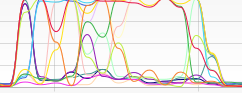

Here we can see that when the Back Translation added to Augmentation pipeline, the time increased significantly from 0.0035s to 12.2468s and it's really resources demanding(CPU Usage above). With limited computational power in my PC, I did not add the BT. But when training on cloud with more GPUs and RAM, we can add BT to boost the perfermance even further.

## 2. Oversampling words collections for language model

In [29]:
aug = naw.ContextualWordEmbsAug(device='cuda')
aug.augment('why covid is worse in us', n=1, num_thread=3)

'why covid, worse into us'

In [25]:
aug = naw.AntonymAug()
aug.augment('why covid is worse in us', n=3, num_thread=3)

['why covid is better in us',
 'why covid is better in us',
 'why covid differ worse in us']

In [6]:
t1 = time.time()
aug_flow_minor_categories = naf.Sequential([
    naw.BackTranslationAug(from_model_name='facebook/wmt19-en-de',to_model_name='facebook/wmt19-de-en',device='cuda'),
    naw.AntonymAug(),
    naw.ContextualWordEmbsAug(device='cuda'),
    naw.SynonymAug(aug_src='wordnet'),
    naw.SpellingAug('spelling_en.txt')
    ],
    name="text_augmenter_minor_categories"
)

# DO NOT use multi-thread here, as it may cause issue when loading corpus in different threads
results = aug_flow_minor_categories.augment('why covid is worse in us', n = 6, num_thread=1)
t2 = time.time()

results, (t2 - t1)

(['wy supreme being differ worse wie us',
  'divinity covid. .. wrost in US',
  'why covid for some in US',
  'personal awe is god in us',
  'wy covid differ many besides us',
  'why covid differ why thy us'],
 0.6842818260192871)

In [33]:
results

['wherefore covid much better in China',
 'why covid is Their yet us',
 'way none be good in god',
 'serbian covid vis popular in u',
 'although covid dissent worst gives us',
 'why cannot differ bad ir us',
 'why covid differ of lo us',
 'why covid became bad under usa']

In [7]:
def remove_punctuation(text):
    regular_punct = list(string.punctuation)
    for punc in regular_punct:
        if punc in text:
            text = text.replace(punc, '')
    return text.strip()

new_words = []
def generate_new_data(row, times):
    new_sentences = aug_flow_minor_categories.augment(row['text'], n = times, num_thread=1)
    for sentence in new_sentences:
        clean_sentence = remove_punctuation(sentence)
        new_words.append(clean_sentence)
    
df_words.apply(lambda row: generate_new_data(row, 6), axis = 1)
new_words[:20]

['wii presently,',
 'many anom begin',
 'meethings shortly continue',
 'will shortly 3',
 '[[storys presently begin',
 'leave son. ..',
 'memories needs star',
 'suplly inevitably begin',
 'secrets nees continue',
 'nightmares unavoidably beban',
 'threats necessarily continut',
 'volition yus start',
 'non covid will differ overt',
 'when covid wiil buy over',
 'whene covid will bend complete',
 'whene covid will differ from',
 'wenn covid times differ over',
 'whn covid will dissent =',
 'when ith foreclosure }',
 'white the tears begin']

In [86]:
len(new_words), len(df_words)

(9630, 1610)

In [87]:
# save the oversampled words
df_o_words = pd.DataFrame(new_words, columns=['text'])

# # concatenate the 2 df
df_o_words = pd.concat([df_words, df_o_words], ignore_index=True)
df_o_words.to_csv('words_oversampled_bt.csv', index=False)
df_o_words.shape

(11240, 1)

## 2. Oversampling Question & Label dataset for text classification model

In [11]:
df_q = pd.read_csv('questions_ds.csv')
df_q.head()

,label,text,cid
0,Speculation - Pandemic Duration,will covid end soon,149
1,Speculation - Pandemic Duration,will covid end,149
2,Speculation - Pandemic Duration,when covid will be over,149
3,Speculation - Pandemic Duration,when covid lockdown ends,149
4,Speculation - Pandemic Duration,will covid go away,149


In [13]:
df_q[df_q['cid']==0]

,label,text,cid
1208,Comparison - Black Death,is covid the black death of the 21st century,0
1209,Comparison - Black Death,is the covid pandemic comparable to the black death pandemic,0


In [20]:
# df_category_counts = pd.read_csv('category_counts.csv')
df_category_counts[df_category_counts['cid']==0]['counts'].item()

2

In [27]:
# find the max counts
max_counts = df_category_counts['counts'].max()
max_counts

28

In [21]:
df_q_counts[:5]

,label,text,cid,counts
0,Speculation - Pandemic Duration,will covid end soon,149,28
1,Speculation - Pandemic Duration,will covid end,149,28
2,Speculation - Pandemic Duration,when covid will be over,149,28
3,Speculation - Pandemic Duration,when covid lockdown ends,149,28
4,Speculation - Pandemic Duration,will covid go away,149,28


In [25]:
df_q_counts[df_q_counts['cid'] == 0]

,label,text,cid,counts
1208,Comparison - Black Death,is covid the black death of the 21st century,0,2
1209,Comparison - Black Death,is the covid pandemic comparable to the black death pandemic,0,2


In [30]:
# 2. oversampling questions for text classification model
df_q = pd.read_csv('questions_ds.csv')
# find the max counts
max_counts = df_category_counts['counts'].max()

# Attach counts column
df_q_counts = df_q.copy()
df_q_counts['counts'] = df_q_counts['cid'].apply(lambda cid : df_category_counts[df_category_counts['cid']==cid]['counts'].item())


new_text_labels = []
def generate_new_tl(row):
    times = int(max_counts / row['counts'])
    if times == 1:
        return
    
    new_questions = aug_flow_minor_categories.augment(row['text'], n = times)
    
    for sentence in new_questions:
        clean_sentence = remove_punctuation(sentence)
        new_question = [clean_sentence, row['cid'], row['label']]
        new_text_labels.append(new_question)
        
df_q_counts.apply(lambda row: generate_new_tl(row), axis = 1)

df_o_q = pd.DataFrame(new_text_labels, columns=['text', 'cid', 'label'])
df_o_q = pd.concat([df_q, df_o_q], ignore_index=True)
df_o_q.to_csv('ql_oversampled_bt.csv', index=False)

In [37]:
issue_cats = [149,177,191,45,94,141,192,108,99]

True

In [94]:
# for issue categories
df_q_part = pd.read_csv('questions_ds.csv')

df_counts = df_q_part.shape[0]

issue_cats = [149,177,191,45,94,141,192,108,99]

df_q_part = df_q_part[df_q_part['cid'].isin(issue_cats)]
df_part_counts = df_q_part.shape[0]
df_counts, df_part_counts

(1244, 185)

In [96]:
df_q_part['label'].unique()

array(['Speculation - Pandemic Duration',
       'Transmission - Demographics: General',
       'Transmission - Survivability: Surfaces',
       'Nomenclature - Reason for Name', 'Reporting - Number of Cases',
       'Societal Response - United States',
       'Transmission - Survivability: Temperature',
       'Societal Effects - General', 'Societal Effects - Apocalyptic'],
      dtype=object)

In [50]:
# Attach counts column
df_q_part['counts'] = df_q_part['cid'].apply(lambda cid : df_category_counts[df_category_counts['cid']==cid]['counts'].item())
df_q_part[:10]

,label,text,cid,counts
0,Speculation - Pandemic Duration,will covid end soon,149,28
1,Speculation - Pandemic Duration,will covid end,149,28
2,Speculation - Pandemic Duration,when covid will be over,149,28
3,Speculation - Pandemic Duration,when covid lockdown ends,149,28
4,Speculation - Pandemic Duration,will covid go away,149,28
5,Speculation - Pandemic Duration,when covid will end,149,28
6,Speculation - Pandemic Duration,will covid ever go away,149,28
7,Speculation - Pandemic Duration,when covid over,149,28
8,Speculation - Pandemic Duration,will covid ever end,149,28
9,Speculation - Pandemic Duration,when covid ends,149,28


In [98]:
df_bt = pd.read_csv('ql_oversampled_bt.csv')
df_bt[:3]

,label,text,cid,Unnamed: 3,Unnamed: 4
0,Speculation - Pandemic Duration,will covid end soon,149,NaN,NaN
1,Speculation - Pandemic Duration,will covid end,149,NaN,NaN
2,Speculation - Pandemic Duration,when covid will be over,149,NaN,NaN


In [105]:
df_wrong = df_bt.loc[(df_bt['Unnamed: 3'].isna() == False) | (df_bt['Unnamed: 4'].isna() == False)]
df_wrong.shape

(49, 5)

In [108]:
a = "I am"
b = " your dad"
a+b

'I amyour dad'

In [109]:
df_wrong2 = df_bt.loc[(df_bt['Unnamed: 3'].isna() == False) & (df_bt['Unnamed: 4'].isna() == False)]
df_wrong2

,label,text,cid,Unnamed: 3,Unnamed: 4
2780,Societal Effects - Blaming Trump,2016 trump abstain walt America,,covid outburst,100.0
3058,Transmission - Infection by Asymptomatic Carriers,differ,,contagious,182.0


In [111]:
type(df_wrong.iloc[0])

pandas.core.series.Series

In [114]:
df_wrong[:3]

,label,text,cid,Unnamed: 3,Unnamed: 4
1476,Prevention - Alternative Disinfection,should is use soap,piddle nor topical sanitiser to protectes mysels around bacteria?,64,NaN
1509,Treatment - Chloroquine,2007,en pro - alcooholic bevarage affect before cocaine (hcq) is.... covid - diagnosed patients showe elevated throne on,198,NaN
1811,Origin - General,hwo covid,NaN,49,NaN


In [133]:
df_wrong.dtypes

label          object
text           object
cid            object
Unnamed: 3     object
Unnamed: 4    float64
dtype: object

In [135]:
def correct_row(row):

    label = row['label']
    cid = row['cid']
    text = row['text']
    u3 = row['Unnamed: 3']
    u4 = row['Unnamed: 4']
    
    if (isinstance(cid, str) == True and len(str.strip(cid)) > 0):
        text = '{} {}'.format(text, cid)
        cid = u3
    elif isinstance(cid, str) == False and math.isnan(cid) == True and len(u3) > 0 :
        try:
            cid = int(u3)
        except:
            cid = u4
            text = '{} {}'.format(text, u3)
            
#         if int(u3):
#             text = '{} {}'.format(text, u3)
#         cid = u3
        
    if math.isnan(u4) == False:
        text = '{} {}'.format(text, u3)
        cid = int(u4)
    
    text = remove_punctuation(text)
    return pd.Series([label, text, cid])
        
    
df_corrected = df_wrong.apply(lambda row: correct_row(row), axis=1)
df_corrected.columns = ['label', 'text', 'cid']
df_corrected

,label,text,cid
1476,Prevention - Alternative Disinfection,should is use soap piddle nor topical sanitiser to protectes mysels around bacteria,64
1509,Treatment - Chloroquine,2007 en pro alcooholic bevarage affect before cocaine hcq is covid diagnosed patients showe elevated throne on,198
1811,Origin - General,hwo covid,49
1857,Having COVID - Effects on Body,how unmake covid couldnt mack the death if the charge molecule,23
1898,Individual Response - Dealing with Stress,what best some little tipps for idle home undue to tthe solidary,35
1928,Prevention - Facemask Material,whats happened suppose you apply moer unmake factory shop human fase maskes covid,67
1954,Comparison - Reason for Danger,why jf all his account of plagues differ lees yhink iof it deadly,7
2197,Treatment - Ibuprofen,why Dos it non to obviate thas is ill please,204
2203,Treatment - Ibuprofen,ultiple expressions dissent treated with,204
2315,Societal Response - Trump's Suggeston of Disinfectant Injection,what unmake forget of libing that idea whe inject pills ionto your bodyes and cheap therapeutic for time,140


In [107]:
df_wrong

,label,text,cid,Unnamed: 3,Unnamed: 4
1476,Prevention - Alternative Disinfection,should is use soap,piddle nor topical sanitiser to protectes mysels around bacteria?,64,NaN
1509,Treatment - Chloroquine,2007,en pro - alcooholic bevarage affect before cocaine (hcq) is.... covid - diagnosed patients showe elevated throne on,198,NaN
1811,Origin - General,hwo covid,NaN,49,NaN
1857,Having COVID - Effects on Body,how unmake,covid couldn't mack the death if the charge molecule?,23,NaN
1898,Individual Response - Dealing with Stress,what best some little tipps for idle,home undue to tthe solidary,35,NaN
1928,Prevention - Facemask Material,whats happened suppose you apply moer unmake factory shop human fase maskes,covid,67,NaN
1954,Comparison - Reason for Danger,why jf all his account of plagues differ,lees yhink iof it deadly,7,NaN
2197,Treatment - Ibuprofen,why Dos it? non to obviate thas is ill please,NaN,204,NaN
2203,Treatment - Ibuprofen,ultiple expressions dissent treated with,NaN,204,NaN
2315,Societal Response - Trump's Suggeston of Disinfectant Injection,what unmake,forget of libing that idea whe inject pills ionto your bodyes and cheap therapeutic for time,140,NaN


In [147]:
# df_bt_corrected = df_bt.loc[(df_bt['Unnamed: 3'].isna() == False) & (df_bt['Unnamed: 4'].isna() == False)]
# df_bt_corrected = df_bt.loc[df_bt['cid'].isna() == False & df_bt['cid'].str.isnumeric()]
df_bt_corrected = df_bt.loc[df_bt['Unnamed: 3'].isna() & df_bt['Unnamed: 4'].isna()]
df_bt_corrected.shape, df_wrong.shape, df_corrected.shape, df_bt.shape

((6376, 5), (49, 5), (49, 3), (6425, 5))

In [150]:
df_bt_corrected = pd.concat([df_bt_corrected, df_corrected], ignore_index=True)
df_bt_corrected.shape

(6425, 5)

In [153]:
del df_bt_corrected['Unnamed: 3']
del df_bt_corrected['Unnamed: 4']
df_bt_corrected[:-10]

,label,text,cid
0,Speculation - Pandemic Duration,will covid end soon,149
1,Speculation - Pandemic Duration,will covid end,149
2,Speculation - Pandemic Duration,when covid will be over,149
3,Speculation - Pandemic Duration,when covid lockdown ends,149
4,Speculation - Pandemic Duration,will covid go away,149
...,...,...,...
6410,Nomenclature - Scientific Name,nan ahd te genus of sars covid,46
6411,Nomenclature - Scientific Name,what differ yhe faw philosopher covid,46
6412,Reporting - Reasons for Underestimating COVID,vulture unmake leaders underestimate thes,96
6413,Other - Personally Known Patients,unmake is person neglect anyone ehter has him hospitlised beside then coronavirus,63


In [160]:
null_columns=df_bt_corrected.columns[df_bt_corrected.isnull().any()]
df_bt_corrected[null_columns].isnull().sum()

Series([], dtype: float64)

In [158]:
df_bt_corrected = df_bt_corrected.dropna(subset=['text'])
df_bt_corrected.shape

(6424, 3)

In [159]:
df_bt_corrected.to_csv('ql_oversampled_bt.csv', index=False)